<a href="https://colab.research.google.com/github/omanofx/portfolio/blob/main/data_wrangling/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Omar Fernández

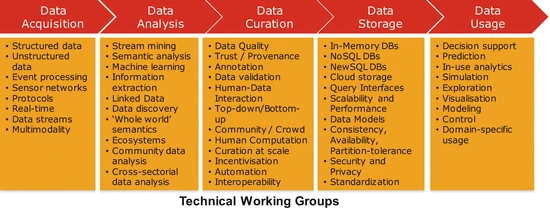

# The Project

# Table of Contents

1. Executive Summary
1. Introduction
  1. Objective of the project
  1. Stakeholders
  1. Project Scope
  1. Assumptions and limitations
  1. Analysis to be performed
  1. Solution
1. Analytical context
  1. Requirements
  1. The Dataset
  1. Data set structure
  1. Data dimensions
  1. Libraries used
  1. Setting
  1. Functions
1. Data acquisition
  1. Github
  1. External data (API)
  1. Backup
1. Data wrangling
  1. Main data set
  1. Target variable
  1. Feature Reduction
  1. Duplicate values
  1. NaN values
  1. Wrong values
  1. Transformation of data types
  1. Categorical variable labeling
  1. Attribute engineering
  1. Outliers
  1. z-score method
  1. IQR method
  1. Secondary data set (optional)
  1. Save files
1. Exploratory Data Analysis (EDA)
  1. EDA Conclusions
1. Feature Selection
  1. Correlation matrix
  1. Stepwise
1. Model training
  1. Split the dataframe
1. Massive model training
  1. Models: Configuration
  1. Comparison
  1. ROC Raven
  1. Bias and Variance
1. Final project results
1. Conclusions and final recommendations
1. References
1. Change log

# Analytical context

## The dataset

This spreadsheet shows historical alternative fueling station counts by state on an annual basis since December 2007. This data is based on the number of public and private (non-residential) stations in the Alternative Fuels Data Center (AFDC) Alternative Fueling Station Locator (https://afdc.energy.gov/stations/) near the end of December each year. You can see total fuel type counts in the "Total" row at the bottom of each tab.

Note that changes in total counts represent both stations that opened and went out of service. For example, if the number of stations increased from 200 to 210 in one year, it could have been that 15 stations opened and 5 stations went out of service.

Please note the following regarding counts for the electric vehicle (EV) charging station data:
 - **Starting in 2011**, EV charging was counted by the outlet rather than by the geographical location.
 - **Beginning in 2014**, the historical data for EV charging includes both the number of EV charging station locations and the number of outlets at each location.  
 - **Starting in 2020**, EV charging data is provided by charger level.

Please note the following regarding counts for propane station data:
 - Starting in 2020, propane station data is broken down by primary or secondary designations.

 Link to original data set: https://www.kaggle.com/datasets/saketpradhan/electric-and-alternative-fuel-charging-stations

## Libraries used

In [1]:
# Visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Otros
import datetime
from datetime import datetime, timedelta
# Configura la zona horaria local
import pytz

# Configuración adicional
%matplotlib inline

# Import warnings module
import warnings
warnings.filterwarnings('ignore')

# File import
import requests
from openpyxl import load_workbook
from io import BytesIO

## Setting

In [2]:
# Configura la zona horaria local
time_zone = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

## Functions

In [3]:
def fecha_hora_local(local_timezone: pytz.timezone = pytz.timezone('America/Argentina/Buenos_Aires')):
    '''
    Esta función muestra la fecha y hora local cada vez que es invocada.
    :param local_timezone: La zona horaria local deseada (por defecto, 'America/Argentina/Buenos_Aires').
    :return: La fecha y hora local en el formato especificado.
    '''
    try:
        # Obtiene la hora local actual en UTC
        utc_now = datetime.utcnow()

        # Convierte la hora actual a la hora local
        local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(local_timezone)

        # Formato de salida para la fecha y hora local
        formato_fecha_hora = "%Y-%m-%d %H:%M:%S"

        # Retorna la fecha y hora local formateada
        return local_time.strftime(formato_fecha_hora)

    except Exception as e:
        # En caso de error, imprime el error y retorna None
        print("Error al obtener la fecha y hora local:", str(e))
        return None

In [4]:
def tiene_espacios_en_blanco(columna: str) -> bool:
    '''
    Verifica si una columna contiene espacios en blanco.
    :param columna: La columna a ser verificada (str).
    :return: True si la columna contiene al menos un espacio en blanco, False de lo contrario.
    '''
    try:
        # Utiliza una expresión generadora y la función any para verificar si
        # alguno de los caracteres es un espacio en blanco
        return any(caracter.isspace() for caracter in columna)

    except Exception as e:
        # En caso de error, imprime el error y retorna False
        print("Error al verificar espacios en blanco en la columna:", str(e))
        return False

In [5]:
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del DataFrame. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    #### Version 2.0
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()
    es_categorica = [True if tipo == 'object' else False for tipo in tipo_dato]
    total_ceros_por_columna = [(columna, (df1[columna] == 0).sum()) for columna in df1.columns]

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No Nulos': valores_no_nulos_por_columna,
        'Total Nulos': total_nulos,
        '% Nulos': round(porcentaje_perdidos, 2),
        'Borrar?': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Total Ceros': [total for columna, total in total_ceros_por_columna],
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: green' if x == 'object' else '',
                  subset=['Tipo de dato'])
        .applymap(lambda x: 'background-color: red' if x > porcentaje_tolerancia else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['% Nulos'] > porcentaje_tolerancia].index, '% Nulos'])
        .background_gradient(cmap='Reds', subset=['% Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['Columna con Espacios']].index, 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )

    return estilo_resultado

In [6]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    Almacena físicamente los datos obtenidos en un archivo CSV.
    :param nombre_archivo: El nombre base del archivo CSV.
    :param df: El DataFrame que se desea guardar en el archivo CSV.
    '''
    try:
        # Obtiene la fecha y hora actual para agregarla al nombre del archivo
        fecha_y_hora_actual = fecha_hora_local(time_zone)

        # Especifica la ruta y el nombre del archivo CSV
        ruta_archivo_csv = f"{nombre_archivo}_{fecha_y_hora_actual}.csv"

        # Guarda el DataFrame en un archivo CSV sin incluir el índice
        df.to_csv(ruta_archivo_csv, index=False)

        # Imprime la fecha y hora de guardado y la ruta del archivo
        print("Fecha y hora:", fecha_y_hora_actual)
        print(f"Los datos se han guardado en el archivo CSV: {ruta_archivo_csv}")

    except Exception as error:
        # Maneja cualquier error que pueda ocurrir durante el proceso de guardado
        print(f"Ocurrió un error al guardar los datos en el archivo CSV: {error}")

In [7]:
def validar_rango_datos(df, column_name, min_value, max_value):
    """
    Función para verificar si hay valores fuera de un rango especificado en una columna de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna que se va a verificar.
    - min_value: Valor mínimo permitido en la columna.
    - max_value: Valor máximo permitido en la columna.

    Retorna:
    - filtered_values: DataFrame que contiene las filas con valores fuera del rango especificado.
    """
    # Filtrar los valores que están fuera del rango especificado
    filtered_values = df[(df[column_name] < min_value) | (df[column_name] > max_value)]

    # Verificar si no hay errores
    if filtered_values.empty:
        print('Esta característica no presenta errores')
        return None
    else:
        print('Se detectaron errores:')
        return filtered_values

In [8]:
def calcular_porcentage(df: pd.DataFrame, column_name: str):
    """
    Calcula el porcentaje de cada valor único en una columna de un DataFrame.

    Parámetros:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column_name (str): El nombre de la columna para la cual se calcularán los porcentajes.

    Retorna:
    pandas.Series: Una serie que contiene los porcentajes de cada valor único en la columna.
    """
    # Verificar si la columna existe en el DataFrame
    if column_name not in df.columns:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
        return None

    # Obtener recuentos de valores únicos en la columna
    value_counts = df[column_name].value_counts()

    # Calcular los porcentajes
    percentages = (value_counts / len(df[column_name])) * 100

    # Asignar un nombre al índice para mayor claridad
    percentages = percentages.rename_axis(column_name)

    return percentages

# Data acquisition

## Github

In [9]:
try:
    df_stations = pd.read_csv('https://raw.githubusercontent.com/omanofx/portfolio/main/data_wrangling/electric_and_alternative_fuel_charging_stations.csv', sep =",")
    print("CSV file has been uploaded successfully.")
    print(fecha_hora_local())

except Exception as e:
    print("An error occurred while uploading the CSV file:", e)

CSV file has been uploaded successfully.
2024-04-15 12:10:15


## Reading the historical excel file

In [10]:
# URL del archivo .xlsx en GitHub
url = 'https://github.com/omanofx/portfolio/raw/main/data_wrangling/historical_station_counts_by_state_2007_2021_normalizado.xlsx'

try:
    # Realizar la solicitud GET al archivo en GitHub
    respuesta = requests.get(url)

    # Verificar si la solicitud fue exitosa (código de estado 200)
    if respuesta.status_code == 200:
        # Leer el contenido del archivo .xlsx en un objeto BytesIO
        contenido_xlsx = BytesIO(respuesta.content)

        # Cargar el archivo .xlsx desde el objeto BytesIO
        libro_trabajo = load_workbook(contenido_xlsx, data_only=True)

        # Seleccionar la hoja de trabajo (worksheet) que deseas leer
        hoja = libro_trabajo.active

        print("File read successfully.")
        print(fecha_hora_local())

        # Cerrar el archivo xlsx después de usarlo
        libro_trabajo.close()
    else:
        print("Could not get the .xlsx file from GitHub. Status code:", respuesta.status_code)

except Exception as e:
    print("An error occurred:", e)


File read successfully.
2024-04-15 12:10:42


In [11]:
libro_trabajo.get_sheet_names()

['About the Data',
 '2021',
 '2020',
 '2019',
 '2018',
 '2017',
 '2016',
 '2015',
 '2014',
 '2013',
 '2012',
 '2011',
 '2010',
 '2009',
 '2008',
 '2007']

In [12]:
# Get the worksheet object for the sheet named "About the Data"
worksheet = libro_trabajo.get_sheet_by_name("About the Data")

# Remove the worksheet
libro_trabajo.remove_sheet(worksheet)

#libro_trabajo.remove_sheet(worksheet)
print(f"These are the sheets available in the file: \n", libro_trabajo.get_sheet_names())

These are the sheets available in the file: 
 ['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007']


In [13]:
# BORRAR
df = pd.read_excel(libro_trabajo, sheet_name='2021', engine='openpyxl', header=1)
df

,State,Biodiesel,CNG,E85,Electrica,Hydrogenb,LNG,Propanec,Totald
0,Alabama,10.0,30.0,33.0,276 | 680,0 | 0 | 0,2.0,26 | 42 | 68,823.0
1,NaN,NaN,NaN,NaN,35 | 527 | 118,NaN,NaN,NaN,NaN
2,Alaska,0.0,1.0,0.0,52 | 94,0 | 0 | 0,0.0,1 | 1 | 2,97.0
3,NaN,NaN,NaN,NaN,3 | 75 | 16,NaN,NaN,NaN,NaN
4,Arizona,75.0,29.0,19.0,"890 | 2,257",0 | 1 | 1,7.0,36 | 33 | 69,2457.0
...,...,...,...,...,...,...,...,...,...
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,(a) Includes legacy chargers but does not incl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,(b) Primary propane stations offer vehicle-spe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,(c) Retail hydrogen stations accept payment at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_years = pd.DataFrame()
sheet_name = 2007

# Leer cada hoja del libro de trabajo
for sheet_name in libro_trabajo.sheetnames:
    sheet = libro_trabajo[sheet_name]
    print(f"Reading sheet: {sheet_name}")

    df = pd.read_excel(libro_trabajo, sheet_name = sheet_name, engine='openpyxl', header= 1, )
    df['year'] = int(sheet_name)  # Asignar el año correspondiente a la columna 'year' en df

    df_years = pd.concat([df_years, df], ignore_index=True)

#print(df_years.head())

Reading sheet: 2021
Reading sheet: 2020
Reading sheet: 2019
Reading sheet: 2018
Reading sheet: 2017
Reading sheet: 2016
Reading sheet: 2015
Reading sheet: 2014
Reading sheet: 2013
Reading sheet: 2012
Reading sheet: 2011
Reading sheet: 2010
Reading sheet: 2009
Reading sheet: 2008
Reading sheet: 2007


In [15]:
df_years

,State,Biodiesel,CNG,E85,Electrica,Hydrogenb,LNG,Propanec,Totald,year,Total,Electric,Hydrogen,Propane
0,Alabama,10.0,30.0,33.0,276 | 680,0 | 0 | 0,2.0,26 | 42 | 68,823.0,2021,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,35 | 527 | 118,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN
2,Alaska,0.0,1.0,0.0,52 | 94,0 | 0 | 0,0.0,1 | 1 | 2,97.0,2021,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3 | 75 | 16,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN
4,Arizona,75.0,29.0,19.0,"890 | 2,257",0 | 1 | 1,7.0,36 | 33 | 69,2457.0,2021,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,Wisconsin,4.0,19.0,84.0,NaN,NaN,0.0,NaN,NaN,2007,152.0,0.0,0.0,45.0
1555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,NaN,NaN,NaN,NaN
1556,Wyoming,14.0,8.0,5.0,NaN,NaN,0.0,NaN,NaN,2007,58.0,0.0,0.0,31.0
1557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,NaN,NaN,NaN,NaN


## Recorre el archivo excel historico tomando los datos de cada hoja

In [17]:
# Crear un DataFrame vacío
df_hojas = pd.DataFrame()

# Especifica la ruta de tu archivo Excel
archivo_excel = url

# Lee el archivo Excel
excel_file = pd.ExcelFile(archivo_excel)

# Obtiene los nombres de las hojas en el archivo Excel
hojas = excel_file.sheet_names

# Elimina la primera hoja
hojas.remove("About the Data")

Hoja: 2007
Hoja: 2008


In [18]:
hojas.clear()

hojas.append("2007")
hojas.append("2008")
hojas.append("2009")
hojas.append("2010")
hojas.append("2011")
hojas.append("2012")
hojas.append("2013")

list_of_df = []

#llenar la lsita de dataframes
print(" --- Inicio de Loop --- ")
for hoja in hojas:
    print("Procesando la hoja: " + hoja)
    df_hojas = pd.read_excel(archivo_excel, sheet_name = hoja, header = 1)

    # Elimina todos los registros cuando todas las columnas sean NaN
    df_hojas = df_hojas.dropna(how = 'all')

    # Agregar una nueva columna 'year' con el nombre de la hoja
    df_hojas['Year'] = int(hoja)

    list_of_df.append(df_hojas)

print(" --- Completado loop --- ")

# Combinar en un Dataframe unico usando concat
#permite pegar los dataframes de la lista
print("Agregando la data")
df_hojas = pd.concat(list_of_df, axis=0)

# Lista de columnas a convertir a tipo entero
columnas_entero = ['Biodiesel', 'CNG', 'E85', 'Electric', 'Hydrogen', 'LNG', 'Propane', 'Total']

# Convertir las columnas especificadas a tipo de datos entero
df_hojas[columnas_entero] = df_hojas[columnas_entero].astype(int)

# Elimina la fila 'Total'
df_hojas.drop(df_hojas[df_hojas['State'] == 'Total'].index, inplace=True)

df_hojas

 --- Inicio de Loop --- 
Procesando la hoja: 2007
Procesando la hoja: 2008
Procesando la hoja: 2009
Procesando la hoja: 2010
Procesando la hoja: 2011
Procesando la hoja: 2012
Procesando la hoja: 2013
 --- Completado loop --- 
Agregando la data


,State,Biodiesel,CNG,E85,Electric,Hydrogen,LNG,Propane,Total,Year
0,Alabama,13,3,3,0,0,0,52,71,2007
2,Alaska,0,1,0,0,0,0,10,11,2007
4,Arizona,10,37,13,12,1,3,58,134,2007
6,Arkansas,3,3,4,0,0,0,41,51,2007
8,California,39,186,6,367,23,29,206,856,2007
...,...,...,...,...,...,...,...,...,...,...
92,Virginia,2,3,1,51,0,0,3,60,2013
94,Washington,33,24,24,1325,1,1,68,1476,2013
96,West Virginia,4,45,115,211,0,1,54,430,2013
98,Wisconsin,2,3,4,42,0,0,12,63,2013


In [ ]:
# replace '0' values with 'nan'
# df[['GLU','PART','GROS','HUR','BMI']] = df[['GLU','PART','GROS','HUR','BMI']].replace(0, np.nan)

In [21]:
analizar_dataframe(df_hojas, 0)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
State,object,357,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Biodiesel,int64,357,0,0.000000,,15,False,357.000000,13.650000,20.630000,0.000000,3.000000,6.000000,15.000000,143.000000
CNG,int64,357,0,0.000000,,25,False,357.000000,18.470000,34.350000,0.000000,3.000000,9.000000,18.000000,258.000000
E85,int64,357,0,0.000000,,37,False,357.000000,42.000000,63.200000,0.000000,3.000000,15.000000,58.000000,364.000000
Electric,int64,357,0,0.000000,,134,False,357.000000,116.850000,395.600000,0.000000,0.000000,3.000000,50.000000,5176.000000
Hydrogen,int64,357,0,0.000000,,237,False,357.000000,1.040000,3.470000,0.000000,0.000000,0.000000,1.000000,26.000000
LNG,int64,357,0,0.000000,,309,False,357.000000,0.970000,4.820000,0.000000,0.000000,0.000000,0.000000,43.000000
Propane,int64,357,0,0.000000,,7,False,357.000000,49.750000,74.070000,0.000000,17.000000,34.000000,57.000000,541.000000
Total,int64,357,0,0.000000,,0,False,357.000000,242.740000,474.340000,6.000000,53.000000,118.000000,223.000000,5903.000000
Year,int64,357,0,0.000000,,0,False,357.000000,2010.000000,2.000000,2007.000000,2008.000000,2010.000000,2012.000000,2013.000000


## Código útiles (borrar)

In [ ]:
# CÓDIGOS UTILES PARA TRABAJAR CON EXCEL
import openpyxl

libro = openpyxl.load_workbook("archivo.xlsx", data_only=True, skiprows = 1)


valor_celda = hoja["A1"].value  # Leer celda A1

rango_celdas = hoja["A1:C10"]  # Leer rango A1 a C10
for fila in rango_celdas:
    for celda in fila:
        print(celda.value)  # Imprime el valor de cada celda

numero_filas = hoja.max_row
numero_columnas = hoja.max_column

primera_fila = hoja[1]  # Acceder a la fila 1
primera_columna = hoja["A"]  # Acceder a la columna A

import pandas as pd

# Convertir la hoja de trabajo en un DataFrame
df = pd.DataFrame(hoja.values)

In [ ]:
sheet_name = '2007'
hoja = libro_trabajo.get_sheet_by_name(sheet_name)

# Inicializa el Dataframe
df_years_2 = pd.DataFrame()


# Iterar sobre las filas de la hoja de trabajo
for fila in hoja.iter_rows(values_only=True, min_row=2):
  print(fila)

  # Procesar cada celda de la fila
  #df['year'] = int(sheet_name)
  df_years_2 = pd.concat([df_years_2, df], ignore_index=True)

    #print(celda, end="\t")  # Imprimir el valor de la celda seguido de una tabulación

  #print()  # Imprimir una nueva línea al final de cada fila

In [ ]:
df_years_2

In [ ]:
hoja = libro_trabajo.get_sheet_by_name("2021")

# Iterar sobre las filas de la hoja de trabajo
for fila in hoja.iter_rows(values_only=True, min_row=2):
    # Procesar cada celda de la fila
    for celda in fila:
        print(celda, end="\t")  # Imprimir el valor de la celda seguido de una tabulación
    print()  # Imprimir una nueva línea al final de cada fila


## Reading the excel file

## Stations

In [ ]:
df_stations.info()

In [ ]:
df_stations.head(5)

In [ ]:
analizar_dataframe(df_stations, 90)

In [ ]:
df_stations.isna().sum().sort_values(ascending=False)

In [ ]:
df_stations['LNG Vehicle Class'].unique()

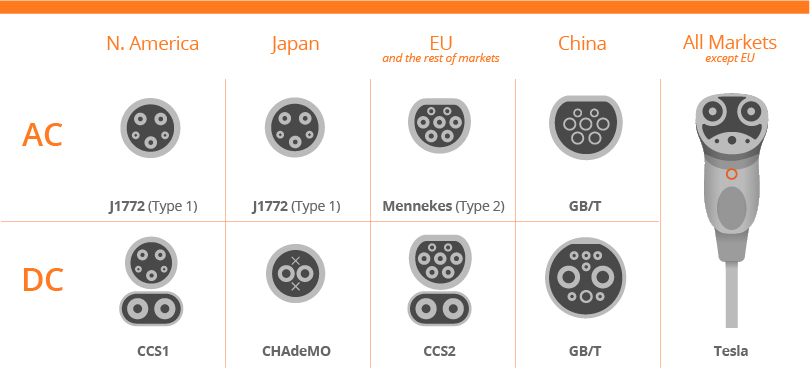

In [ ]:
ev_connector_types = ["J1772",
                      "CHADEMO",
                      "COMBO",
                      "NEMA515",
                      "NEMA520",
                      "NEMA1450",
                      "TESLA"
                      ""
                      ]

In [ ]:
# Completa los valores NaN con el valor 'unknown'
df_stations['EV Connector Types'].fillna('unknown', inplace=True)

In [ ]:
df_stations['EV Connector Types'].value_counts()

In [ ]:

df_stations['EV Connector Types'] = df_stations['EV Connector Types'].replace('J1772 J1772COMBO', 'J1772 COMBO')

In [ ]:
# prompt: buscar 'tesla' en df_stations['EV Connector Types']

mask = df_stations['EV Connector Types'].str.contains('CHADEMO')
df_stations[mask]


In [ ]:
df_stations['EV Connector Types'].unique()

In [ ]:
df_stations['EV Other Info'].unique()

In [ ]:
df_stations['EV Pricing'].unique()

In [ ]:
df_stations['EV On-Site Renewable Source'].unique()

In [ ]:
df_stations['BD Blends (French)'].unique()

In [ ]:
df_stations['Intersection Directions (French)'].unique()

## Feature Reduction

In [ ]:
try:
  df_stations.drop(["Plus4",
                    "LNG Vehicle Class",
                    "Intersection Directions (French)",
                    "Access Days Time (French)",
                    "Groups With Access Code (French)",
                    "LNG On-Site Renewable Source",
                    "EV Level1 EVSE Num",
                    "EV Other Info",
                    "Hydrogen Status Link",
                    "BD Blends (French)",
                    "Hydrogen Is Retail",
                    "CNG Storage Capacity",
                    "Hydrogen Pressures",
                    "Hydrogen Standards",
                    "EV On-Site Renewable Source"
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

In [ ]:
try:
  df_stations.drop(["EV DC Fast Count",
                    "Access Detail Code",
                    "E85 Blender Pump",
                    "Intersection Directions",
                    "EV Pricing (French)",
                    "LPG Primary",
                    "LPG Nozzle Types",
                    "NG Vehicle Class",
                    "CNG Vehicle Class",
                    "NG Fill Type Code",
                    "CNG Fill Type Code",
                    "CNG PSI",
                    "NG PSI",
                    "E85 Other Ethanol Blends",
                    "Expected Date",
                    "BD Blends",
                    "CNG Dispenser Num",
                    "Federal Agency Code",
                    "Federal Agency ID",
                    "Federal Agency Name",
                    "CNG On-Site Renewable Source",
                    "CNG Total Compression Capacity",
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

In [ ]:
try:
  df_stations.drop(["ID"
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)